# Model Comparison: ResNet, Quantized ResNet, EfficientNet, MobileNet

This notebook compares the performance of four image classification models:
1. **ResNet-18 (Baseline)**
2. **Quantized ResNet-18**
3. **EfficientNet-B0**
4. **MobileNetV3-Small**

The goal is to analyze the trade-off between model size and accuracy.
We will evaluate these models on multiple datasets (CIFAR-100, Food-101, Fashion-MNIST, Stanford Cars).
Plots will be saved as high-resolution PNGs.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization as quantization
from torch.quantization import get_default_qconfig, prepare, convert
from torch.ao.quantization import get_default_qat_qconfig, prepare_qat
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import os
import copy
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Configuration
CONFIG = {
    'batch_size': 64,
    'num_workers': 8,
    'learning_rate': 0.001,
    'num_epochs': 5,  
    'qat_epochs': 3,   
    'data_dir': './data',
    'results_dir': './results',
    'seed': 42,
}

# Dataset configurations
DATASETS = {
    'cifar100': {
        'num_classes': 100,
        'input_size': 224,
        'mean': (0.5071, 0.4867, 0.4408),
        'std': (0.2675, 0.2565, 0.2761),
    },
    'food101': {
        'num_classes': 101,
        'input_size': 224,
        'mean': (0.485, 0.456, 0.406),
        'std': (0.229, 0.224, 0.225),
    },
    'fashion_mnist': {
        'num_classes': 10,
        'input_size': 224,
        'mean': (0.2860,),
        'std': (0.3530,),
    },
    # 'stanford_cars': { # Commented out as it might require manual download
    #     'num_classes': 196,
    #     'input_size': 224,
    #     'mean': (0.485, 0.456, 0.406),
    #     'std': (0.229, 0.224, 0.225),
    # },
}

# Set random seeds
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Create directories
os.makedirs(CONFIG['data_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

## Exploratory Data Analysis


We explore the data features in seaborn as in HWs and provide basic insights for the 3 datasets used in this project: CIFAR-100, Food-101, and Fashion-MNIST.

**Write a short paragraph to describe the features of the dataset. What is the number of classes for your target variable?**

The CIFAR-10 dataset contains 60,000 color images at 32×32 resolution,grouped into 10 classes such as airplanes, cars, birds, and dogs. Each image has 3 color channels (RGB), and the classes are balanced with 6,000 examples each. The target variable consists of 10 distinct classes.

### EDA Functions

In [3]:
import torchvision
from torchvision import datasets, transforms

def load_eda_dataset(dataset_name, data_dir='./data'):
    """Load dataset for EDA with simple normalization."""
    if dataset_name == 'cifar100':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        trainset = datasets.CIFAR100(root=data_dir, train=True, download=True, transform=transform)
        testset = datasets.CIFAR100(root=data_dir, train=False, download=True, transform=transform)
        num_classes = 100
        is_grayscale = False
        
    elif dataset_name == 'fashion_mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        trainset = datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
        testset = datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)
        num_classes = 10
        is_grayscale = True
        
    elif dataset_name == 'food101':
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        trainset = datasets.Food101(root=data_dir, split='train', download=True, transform=transform)
        testset = datasets.Food101(root=data_dir, split='test', download=True, transform=transform)
        num_classes = 101
        is_grayscale = False
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    return trainset, testset, num_classes, is_grayscale

def imshow(img, is_grayscale=False):
    """Unnormalize and display image tensor."""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if is_grayscale:
        plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

def run_eda(dataset_name, data_dir='./data'):
    """Run complete EDA for a given dataset."""
    print(f"\n{'='*20} {dataset_name.upper()} EDA {'='*20}")
    
    # Load dataset
    trainset, testset, num_classes, is_grayscale = load_eda_dataset(dataset_name, data_dir)
    
    # Print basic stats
    print(f"\nDataset: {dataset_name}")
    print(f"Number of training samples: {len(trainset)}")
    print(f"Number of testing samples: {len(testset)}")
    print(f"Number of classes: {num_classes}")
    
    # Create dataloader and check normalization
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    images, labels = next(iter(trainloader))
    
    print(f"\nNormalization check:")
    print(f"Image tensor min: {images.min():.4f}, max: {images.max():.4f}")
    print(f"Image shape: {images.shape}")
    print(f"Sample label: {labels[0].item()}")
    
    # Get class names if available
    class_names = getattr(trainset, 'classes', None)
    
    # Plot sample images
    loader_12 = torch.utils.data.DataLoader(trainset, batch_size=12, shuffle=True)
    images, labels = next(iter(loader_12))
    
    plt.figure(figsize=(12, 6))
    imshow(torchvision.utils.make_grid(images), is_grayscale)
    
    if class_names:
        label_str = ", ".join([class_names[l] for l in labels])
        plt.title(f"{dataset_name.upper()} Sample Images\nLabels: {label_str}")
    else:
        plt.title(f"{dataset_name.upper()} Sample Images\nLabels: {labels.tolist()}")
    
    plt.tight_layout()
    plt.show()
    
    return trainset, testset


==================== CIFAR100 EDA ====================

Dataset: cifar100
Number of training samples: 50000
Number of testing samples: 10000
Number of classes: 100

Normalization check:
Image tensor min: -1.0000, max: 1.0000
Image shape: torch.Size([64, 3, 32, 32])
Sample label: 27


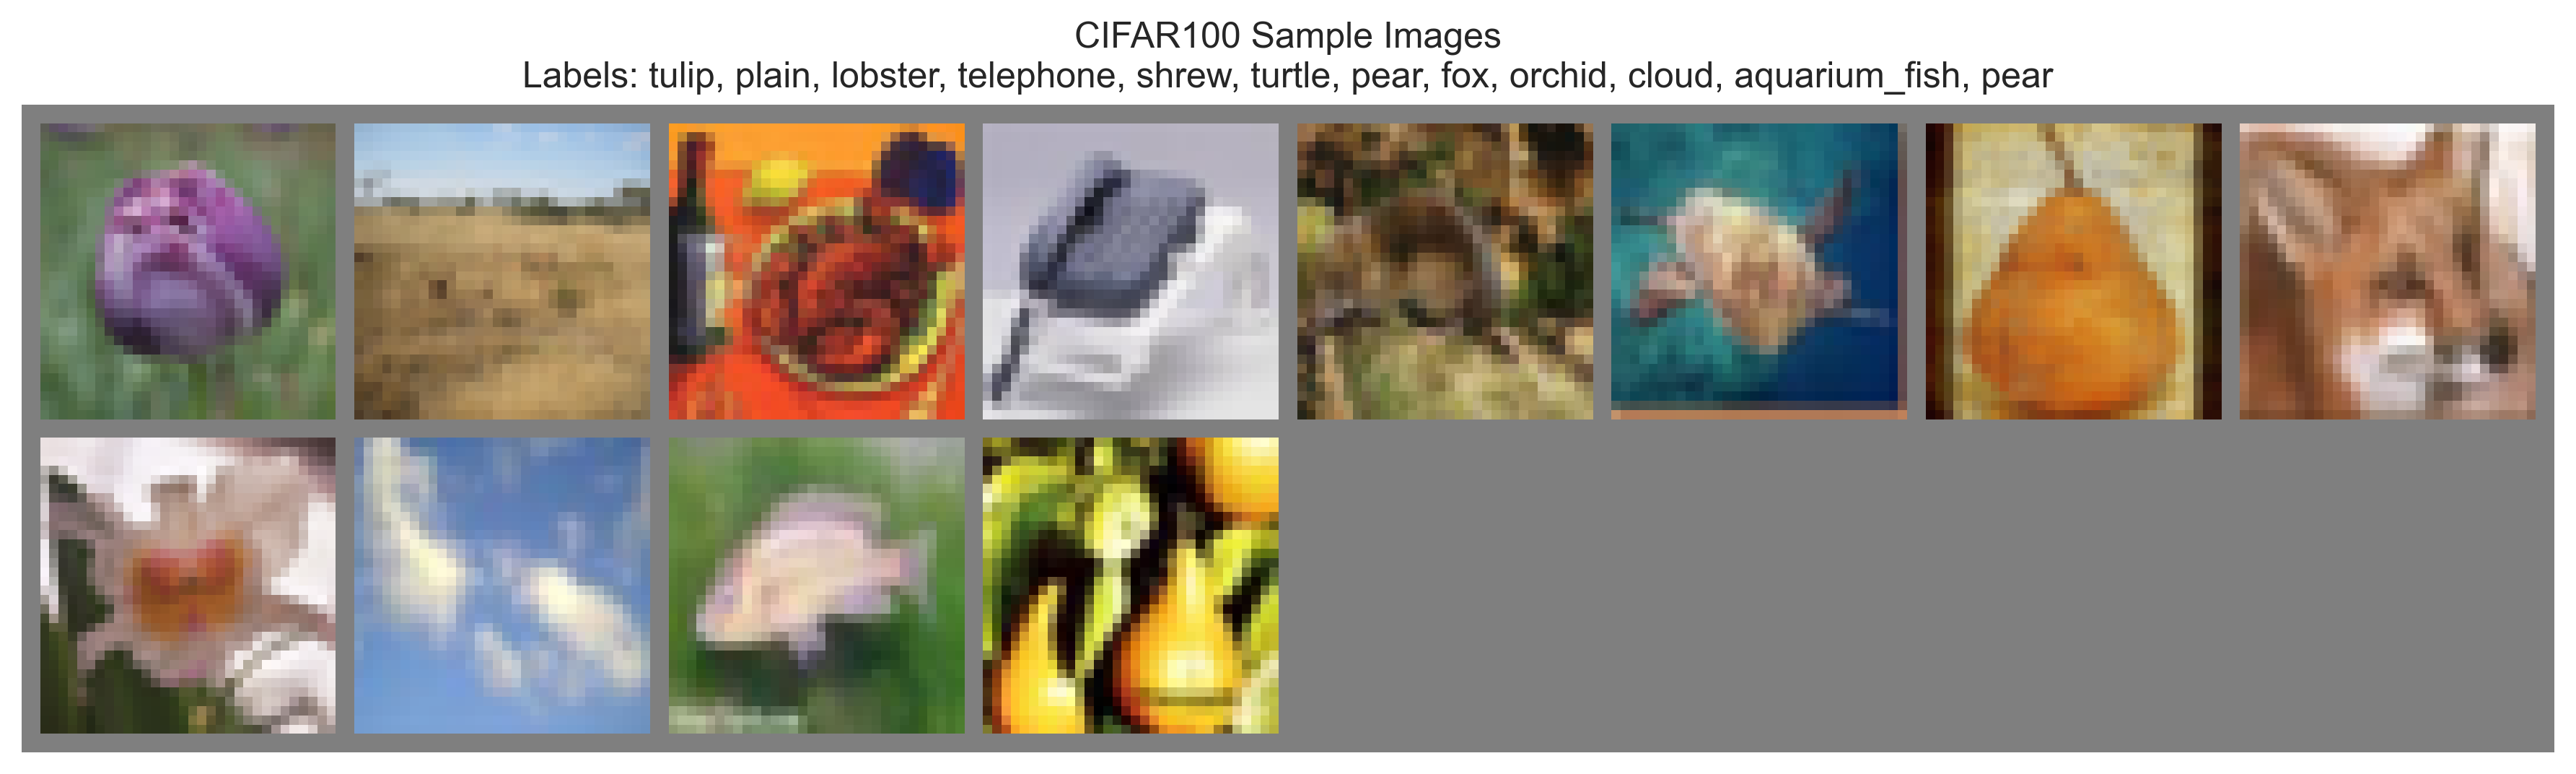


==================== FOOD101 EDA ====================

Dataset: food101
Number of training samples: 75750
Number of testing samples: 25250
Number of classes: 101

Normalization check:
Image tensor min: -1.0000, max: 1.0000
Image shape: torch.Size([64, 3, 224, 224])
Sample label: 35


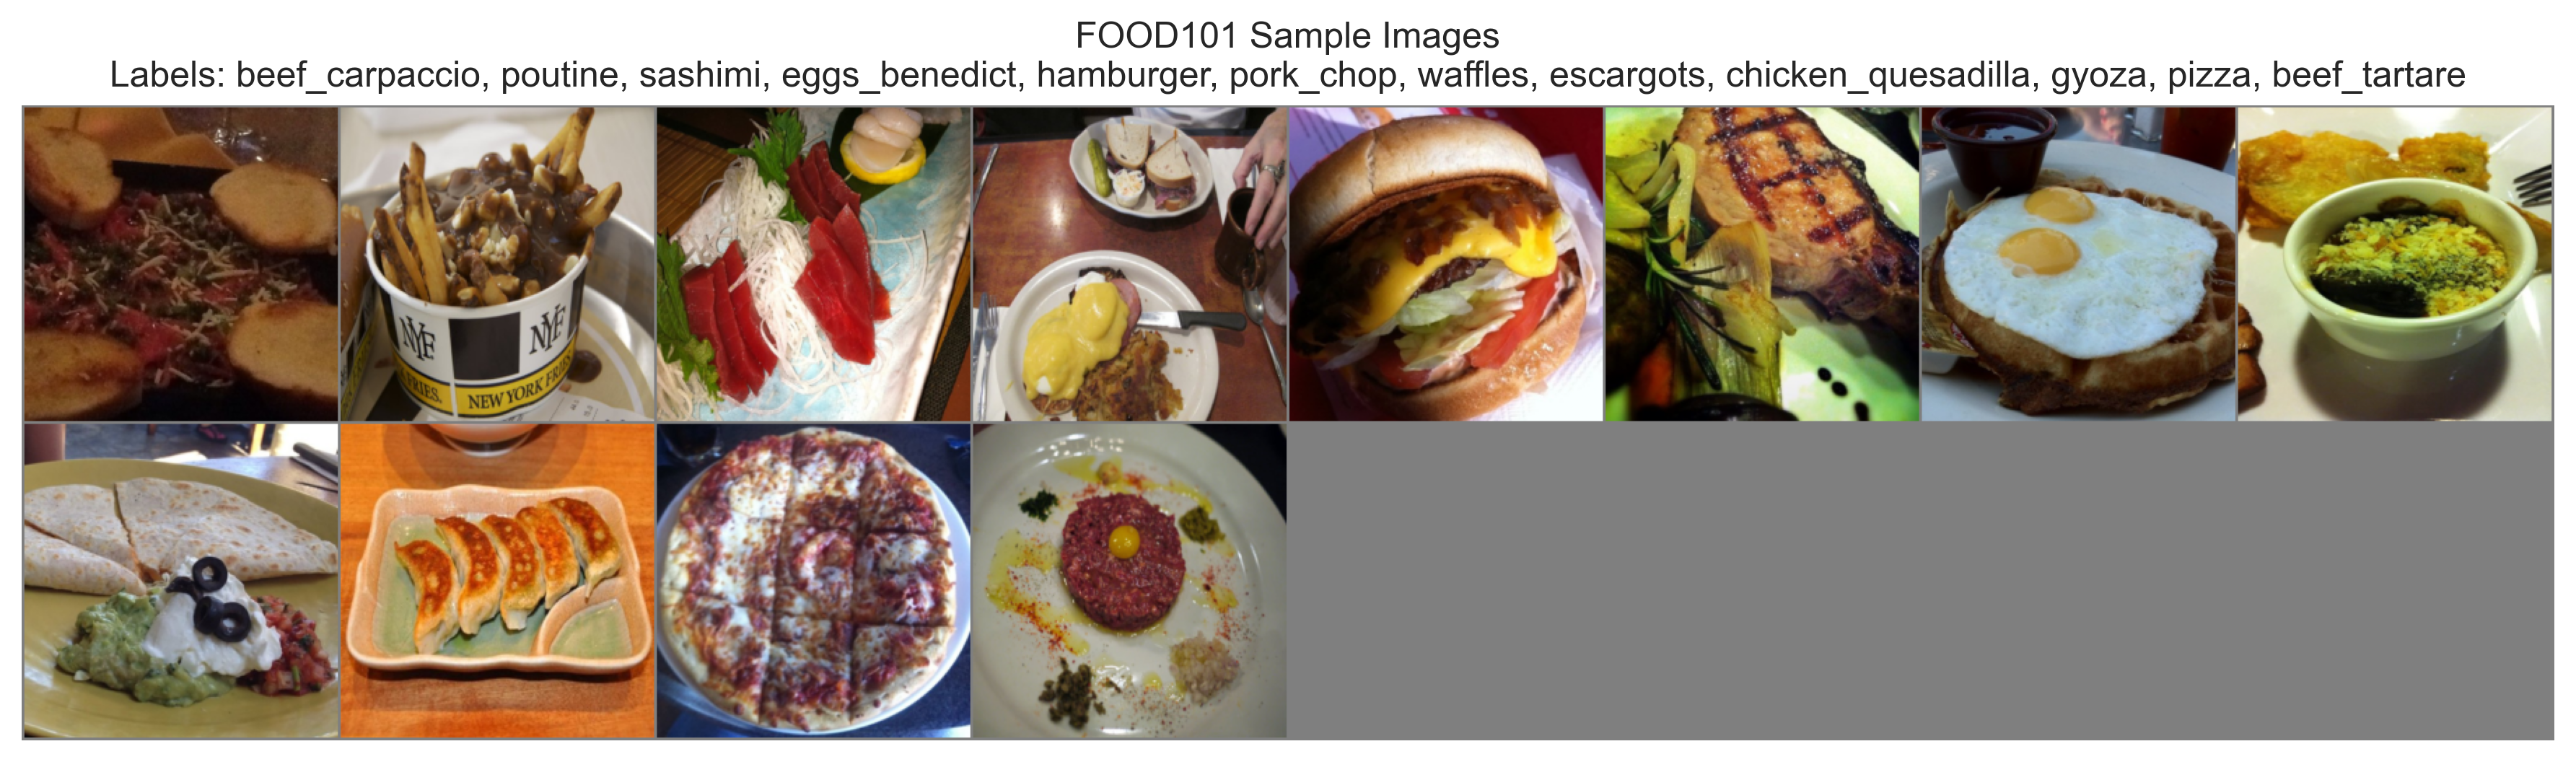


==================== FASHION_MNIST EDA ====================

Dataset: fashion_mnist
Number of training samples: 60000
Number of testing samples: 10000
Number of classes: 10

Normalization check:
Image tensor min: -1.0000, max: 1.0000
Image shape: torch.Size([64, 1, 28, 28])
Sample label: 5


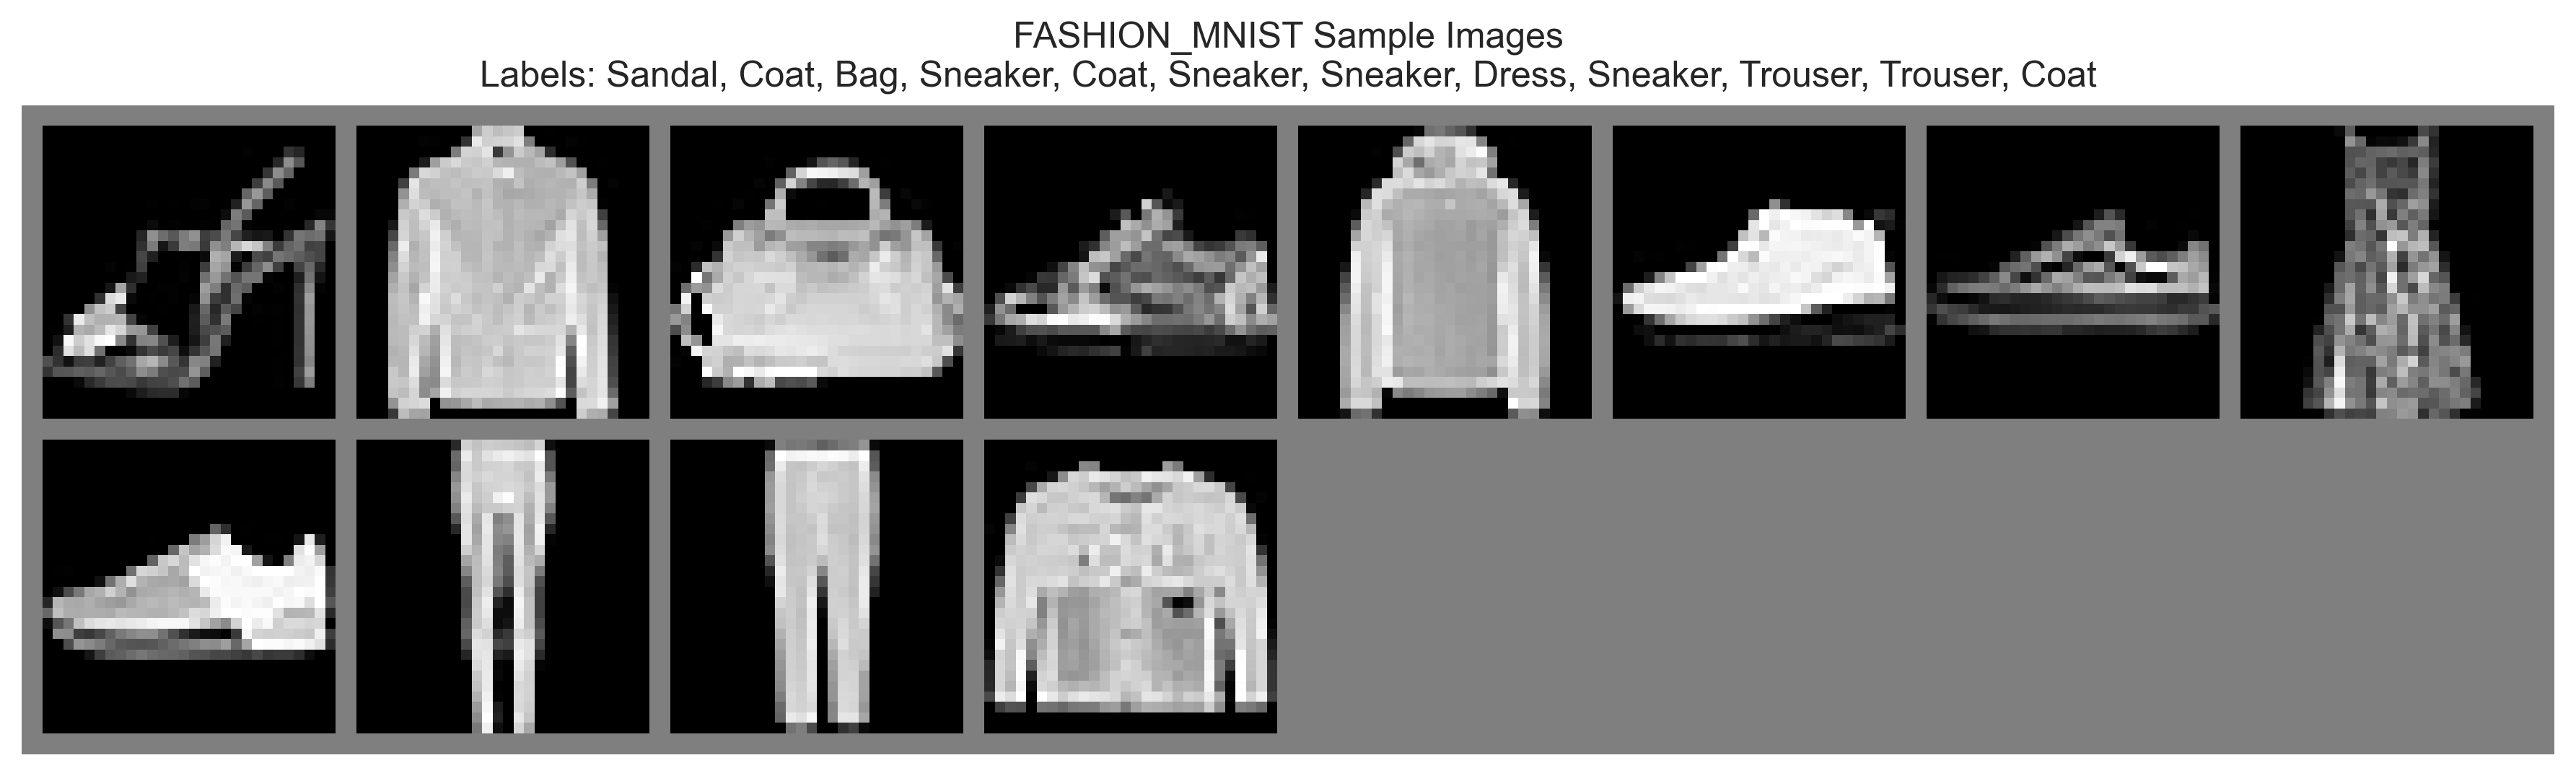

In [4]:
# Run EDA for all datasets
for dataset_name in DATASETS.keys():
    run_eda(dataset_name, CONFIG['data_dir'])

In [5]:
def get_transforms(dataset_name, is_train=True):
    """Get transforms for each dataset."""
    config = DATASETS[dataset_name]
    input_size = config['input_size']
    mean = config['mean']
    std = config['std']

    if dataset_name == 'fashion_mnist':
        if is_train:
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize((input_size, input_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(mean * 3, std * 3),
            ])
        else:
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean * 3, std * 3),
            ])
    else:
        if is_train:
            transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])

    return transform

def load_dataset(dataset_name, subset_size=None):
    """Load dataset with train/val/test splits."""
    data_dir = CONFIG['data_dir']
    train_transform = get_transforms(dataset_name, is_train=True)
    test_transform = get_transforms(dataset_name, is_train=False)

    if dataset_name == 'cifar100':
        train_dataset = torchvision.datasets.CIFAR100(root=data_dir, train=True, download=True, transform=train_transform)
        test_dataset = torchvision.datasets.CIFAR100(root=data_dir, train=False, download=True, transform=test_transform)
        calib_dataset = torchvision.datasets.CIFAR100(root=data_dir, train=True, download=False, transform=test_transform)
    elif dataset_name == 'food101':
        train_dataset = torchvision.datasets.Food101(root=data_dir, split='train', download=True, transform=train_transform)
        test_dataset = torchvision.datasets.Food101(root=data_dir, split='test', download=True, transform=test_transform)
        calib_dataset = torchvision.datasets.Food101(root=data_dir, split='train', download=False, transform=test_transform)
    elif dataset_name == 'fashion_mnist':
        train_dataset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=train_transform)
        test_dataset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=test_transform)
        calib_dataset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=False, transform=test_transform)
    elif dataset_name == 'stanford_cars':
        try:
            train_dataset = torchvision.datasets.StanfordCars(root=data_dir, split='train', download=True, transform=train_transform)
            test_dataset = torchvision.datasets.StanfordCars(root=data_dir, split='test', download=True, transform=test_transform)
            calib_dataset = torchvision.datasets.StanfordCars(root=data_dir, split='train', download=False, transform=test_transform)
        except:
            return None, None, None
    else:
        return None, None, None

    if subset_size is not None:
        train_indices = np.random.choice(len(train_dataset), min(subset_size, len(train_dataset)), replace=False)
        test_indices = np.random.choice(len(test_dataset), min(subset_size // 5, len(test_dataset)), replace=False)
        calib_indices = np.random.choice(len(calib_dataset), min(1000, len(calib_dataset)), replace=False)
        
        train_dataset = Subset(train_dataset, train_indices)
        test_dataset = Subset(test_dataset, test_indices)
        calib_dataset = Subset(calib_dataset, calib_indices)
    else:
        calib_indices = np.random.choice(len(calib_dataset), min(1000, len(calib_dataset)), replace=False)
        calib_dataset = Subset(calib_dataset, calib_indices)

    return train_dataset, test_dataset, calib_dataset

def get_dataloaders(dataset_name, subset_size=None):
    train_dataset, test_dataset, calib_dataset = load_dataset(dataset_name, subset_size)
    if train_dataset is None: return None, None, None

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)
    calib_loader = DataLoader(calib_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)
    
    return train_loader, test_loader, calib_loader

In [6]:
def create_resnet_model(num_classes, pretrained=True):
    """Create ResNet-18 model."""
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def create_quantizable_resnet(num_classes, pretrained=True):
    """Create quantizable ResNet-18 model."""
    model = models.quantization.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None, quantize=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def create_efficientnet_model(num_classes, pretrained=True):
    """Create EfficientNet-B0 model."""
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def create_mobilenet_model(num_classes, pretrained=True):
    """Create MobileNetV3-Small model."""
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1 if pretrained else None)
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    return model

def apply_static_quantization(model, calib_loader, num_classes):
    """Apply static quantization to the model."""
    # Create a quantizable model instance
    quantizable_model = create_quantizable_resnet(num_classes, pretrained=False)
    
    # Load weights from the trained model
    quantizable_model.load_state_dict(model.state_dict(), strict=False)
    
    quantizable_model.eval()
    quantizable_model.to('cpu')
    
    # Fuse modules
    quantizable_model.fuse_model()
    
    quantizable_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    model_prepared = torch.quantization.prepare(quantizable_model, inplace=False)
    
    # Calibrate
    print("Calibrating model for quantization...")
    with torch.no_grad():
        for inputs, _ in tqdm(calib_loader, desc="Calibration"):
            model_prepared(inputs)
            
    quantized_model = torch.quantization.convert(model_prepared, inplace=False)
    return quantized_model

In [7]:
def train_model(model, train_loader, test_loader, num_epochs, device, lr=0.001):
    """Train the model."""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': f'{running_loss/total:.4f}', 'acc': f'{100.*correct/total:.2f}%'})
            
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
        val_loss /= len(test_loader)
        val_acc = 100. * correct / total
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%')
        
    return model, history

def evaluate_model(model, test_loader, device='cpu'):
    """Evaluate model accuracy."""
    if isinstance(device, str): device = torch.device(device)
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

def get_model_size(model):
    """Get model size in MB."""
    torch.save(model.state_dict(), "temp_model.pt")
    size_mb = os.path.getsize("temp_model.pt") / (1024 * 1024)
    os.remove("temp_model.pt")
    return size_mb

def measure_inference_time(model, test_loader, device='cpu', num_batches=50):
    """Measure average inference time per batch (ms)."""
    if isinstance(device, str): device = torch.device(device)
    model = model.to(device)
    model.eval()
    
    # Warmup
    warmup_input = next(iter(test_loader))[0].to(device)
    for _ in range(10):
        with torch.no_grad(): _ = model(warmup_input)
        
    start_time = time.time()
    batch_count = 0
    with torch.no_grad():
        for inputs, _ in test_loader:
            if batch_count >= num_batches: break
            inputs = inputs.to(device)
            if device.type == 'cuda': torch.cuda.synchronize()
            _ = model(inputs)
            if device.type == 'cuda': torch.cuda.synchronize()
            batch_count += 1
            
    end_time = time.time()
    avg_time = (end_time - start_time) / batch_count * 1000 # ms
    return avg_time

In [8]:
# Main Execution Loop
results = []

for dataset_name in DATASETS.keys():
    print(f"\n{'='*20} Processing Dataset: {dataset_name} {'='*20}")
    
    # Load Data
    train_loader, test_loader, calib_loader = get_dataloaders(dataset_name, subset_size=None) # Set subset_size=1000 for quick testing
    if train_loader is None:
        print(f"Skipping {dataset_name}")
        continue
        
    num_classes = DATASETS[dataset_name]['num_classes']
    
    # Define Models to Train
    models_to_train = {
        'ResNet-18': create_resnet_model(num_classes),
        'EfficientNet-B0': create_efficientnet_model(num_classes),
        'MobileNetV3-Small': create_mobilenet_model(num_classes)
    }
    
    trained_models = {}
    
    # Train Models
    for name, model in models_to_train.items():
        print(f"\nTraining {name}...")
        model, _ = train_model(model, train_loader, test_loader, CONFIG['num_epochs'], device)
        trained_models[name] = model
        
        # Evaluate
        acc = evaluate_model(model, test_loader, device)
        size = get_model_size(model)
        latency = measure_inference_time(model, test_loader, device)
        
        results.append({
            'Dataset': dataset_name,
            'Model': name,
            'Accuracy': acc,
            'Size (MB)': size,
            'Latency (ms)': latency
        })
        print(f"{name}: Acc={acc:.2f}%, Size={size:.2f}MB, Latency={latency:.2f}ms")

    # Quantize ResNet
    print(f"\nQuantizing ResNet-18...")
    resnet_model = trained_models['ResNet-18']
    # Move to CPU for quantization
    resnet_model.to('cpu')
    quantized_resnet = apply_static_quantization(resnet_model, calib_loader, num_classes)
    
    # Evaluate Quantized Model
    q_acc = evaluate_model(quantized_resnet, test_loader, device='cpu')
    q_size = get_model_size(quantized_resnet)
    q_latency = measure_inference_time(quantized_resnet, test_loader, device='cpu')
    
    results.append({
        'Dataset': dataset_name,
        'Model': 'Quantized ResNet-18',
        'Accuracy': q_acc,
        'Size (MB)': q_size,
        'Latency (ms)': q_latency
    })
    print(f"Quantized ResNet-18: Acc={q_acc:.2f}%, Size={q_size:.2f}MB, Latency={q_latency:.2f}ms")

# Create DataFrame
df_results = pd.DataFrame(results)
print("\nFinal Results:")
print(df_results)
df_results.to_csv(os.path.join(CONFIG['results_dir'], 'model_comparison_results.csv'), index=False)


==================== Processing Dataset: cifar100 ====================

Training ResNet-18...


Epoch 1/5: 100%|██████████| 782/782 [00:35<00:00, 21.74it/s, loss=0.0321, acc=44.65%]


Epoch 1: Train Acc=44.65%, Val Acc=51.89%


Epoch 2/5: 100%|██████████| 782/782 [00:35<00:00, 21.90it/s, loss=0.0211, acc=60.79%]


Epoch 2: Train Acc=60.79%, Val Acc=59.98%


Epoch 3/5: 100%|██████████| 782/782 [00:36<00:00, 21.61it/s, loss=0.0172, acc=67.54%]


Epoch 3: Train Acc=67.54%, Val Acc=66.49%


Epoch 4/5: 100%|██████████| 782/782 [00:36<00:00, 21.40it/s, loss=0.0145, acc=72.19%]


Epoch 4: Train Acc=72.19%, Val Acc=67.65%


Epoch 5/5: 100%|██████████| 782/782 [00:36<00:00, 21.50it/s, loss=0.0125, acc=75.72%]


Epoch 5: Train Acc=75.72%, Val Acc=68.08%


Evaluating: 100%|██████████| 157/157 [00:16<00:00,  9.69it/s]


ResNet-18: Acc=68.08%, Size=42.91MB, Latency=297.94ms

Training EfficientNet-B0...


Epoch 1/5: 100%|██████████| 782/782 [00:50<00:00, 15.52it/s, loss=0.0231, acc=59.24%]


Epoch 1: Train Acc=59.24%, Val Acc=72.52%


Epoch 2/5: 100%|██████████| 782/782 [00:52<00:00, 14.77it/s, loss=0.0140, acc=73.11%]


Epoch 2: Train Acc=73.11%, Val Acc=75.47%


Epoch 3/5: 100%|██████████| 782/782 [00:51<00:00, 15.31it/s, loss=0.0111, acc=78.43%]


Epoch 3: Train Acc=78.43%, Val Acc=77.40%


Epoch 4/5: 100%|██████████| 782/782 [00:50<00:00, 15.34it/s, loss=0.0094, acc=81.15%]


Epoch 4: Train Acc=81.15%, Val Acc=76.96%


Epoch 5/5: 100%|██████████| 782/782 [00:50<00:00, 15.59it/s, loss=0.0082, acc=83.50%]


Epoch 5: Train Acc=83.50%, Val Acc=77.75%


Evaluating: 100%|██████████| 157/157 [00:16<00:00,  9.61it/s]


EfficientNet-B0: Acc=77.75%, Size=16.06MB, Latency=299.28ms

Training MobileNetV3-Small...


Epoch 1/5: 100%|██████████| 782/782 [00:31<00:00, 24.66it/s, loss=0.0230, acc=58.84%]


Epoch 1: Train Acc=58.84%, Val Acc=51.04%


Epoch 2/5: 100%|██████████| 782/782 [00:31<00:00, 24.66it/s, loss=0.0143, acc=72.56%]


Epoch 2: Train Acc=72.56%, Val Acc=67.98%


Epoch 3/5: 100%|██████████| 782/782 [00:31<00:00, 24.60it/s, loss=0.0115, acc=77.29%]


Epoch 3: Train Acc=77.29%, Val Acc=67.62%


Epoch 4/5: 100%|██████████| 782/782 [00:31<00:00, 24.67it/s, loss=0.0097, acc=80.50%]


Epoch 4: Train Acc=80.50%, Val Acc=66.79%


Epoch 5/5: 100%|██████████| 782/782 [00:31<00:00, 24.74it/s, loss=0.0085, acc=82.69%]


Epoch 5: Train Acc=82.69%, Val Acc=67.20%


Evaluating: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s]


MobileNetV3-Small: Acc=67.20%, Size=6.31MB, Latency=295.87ms

Quantizing ResNet-18...
Calibrating model for quantization...


Evaluating: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s]


Quantized ResNet-18: Acc=68.01%, Size=10.84MB, Latency=397.95ms

==================== Processing Dataset: food101 ====================

Training ResNet-18...


Epoch 1/5: 100%|██████████| 1184/1184 [01:33<00:00, 12.63it/s, loss=0.0386, acc=38.70%]


Epoch 1: Train Acc=38.70%, Val Acc=51.58%


Epoch 2/5: 100%|██████████| 1184/1184 [00:53<00:00, 22.28it/s, loss=0.0276, acc=54.61%]


Epoch 2: Train Acc=54.61%, Val Acc=59.13%


Epoch 3/5: 100%|██████████| 1184/1184 [00:49<00:00, 23.93it/s, loss=0.0233, acc=60.87%]


Epoch 3: Train Acc=60.87%, Val Acc=60.36%


Epoch 4/5: 100%|██████████| 1184/1184 [00:49<00:00, 23.92it/s, loss=0.0205, acc=65.13%]


Epoch 4: Train Acc=65.13%, Val Acc=66.70%


Epoch 5/5: 100%|██████████| 1184/1184 [00:49<00:00, 23.75it/s, loss=0.0182, acc=68.53%]


Epoch 5: Train Acc=68.53%, Val Acc=65.80%


Evaluating: 100%|██████████| 395/395 [00:22<00:00, 17.33it/s]


ResNet-18: Acc=65.80%, Size=42.91MB, Latency=343.36ms

Training EfficientNet-B0...


Epoch 1/5: 100%|██████████| 1184/1184 [01:06<00:00, 17.80it/s, loss=0.0271, acc=56.20%]


Epoch 1: Train Acc=56.20%, Val Acc=74.08%


Epoch 2/5: 100%|██████████| 1184/1184 [01:05<00:00, 18.02it/s, loss=0.0177, acc=69.90%]


Epoch 2: Train Acc=69.90%, Val Acc=77.16%


Epoch 3/5: 100%|██████████| 1184/1184 [01:05<00:00, 18.11it/s, loss=0.0149, acc=74.14%]


Epoch 3: Train Acc=74.14%, Val Acc=77.75%


Epoch 4/5: 100%|██████████| 1184/1184 [01:05<00:00, 18.13it/s, loss=0.0130, acc=76.96%]


Epoch 4: Train Acc=76.96%, Val Acc=79.55%


Epoch 5/5: 100%|██████████| 1184/1184 [01:05<00:00, 18.10it/s, loss=0.0116, acc=79.23%]


Epoch 5: Train Acc=79.23%, Val Acc=79.96%


Evaluating: 100%|██████████| 395/395 [00:22<00:00, 17.37it/s]


EfficientNet-B0: Acc=79.96%, Size=16.07MB, Latency=316.48ms

Training MobileNetV3-Small...


Epoch 1/5: 100%|██████████| 1184/1184 [00:50<00:00, 23.54it/s, loss=0.0314, acc=49.48%]


Epoch 1: Train Acc=49.48%, Val Acc=61.53%


Epoch 2/5:  55%|█████▍    | 646/1184 [00:36<00:30, 17.72it/s, loss=0.0225, acc=62.15%]


KeyboardInterrupt: 

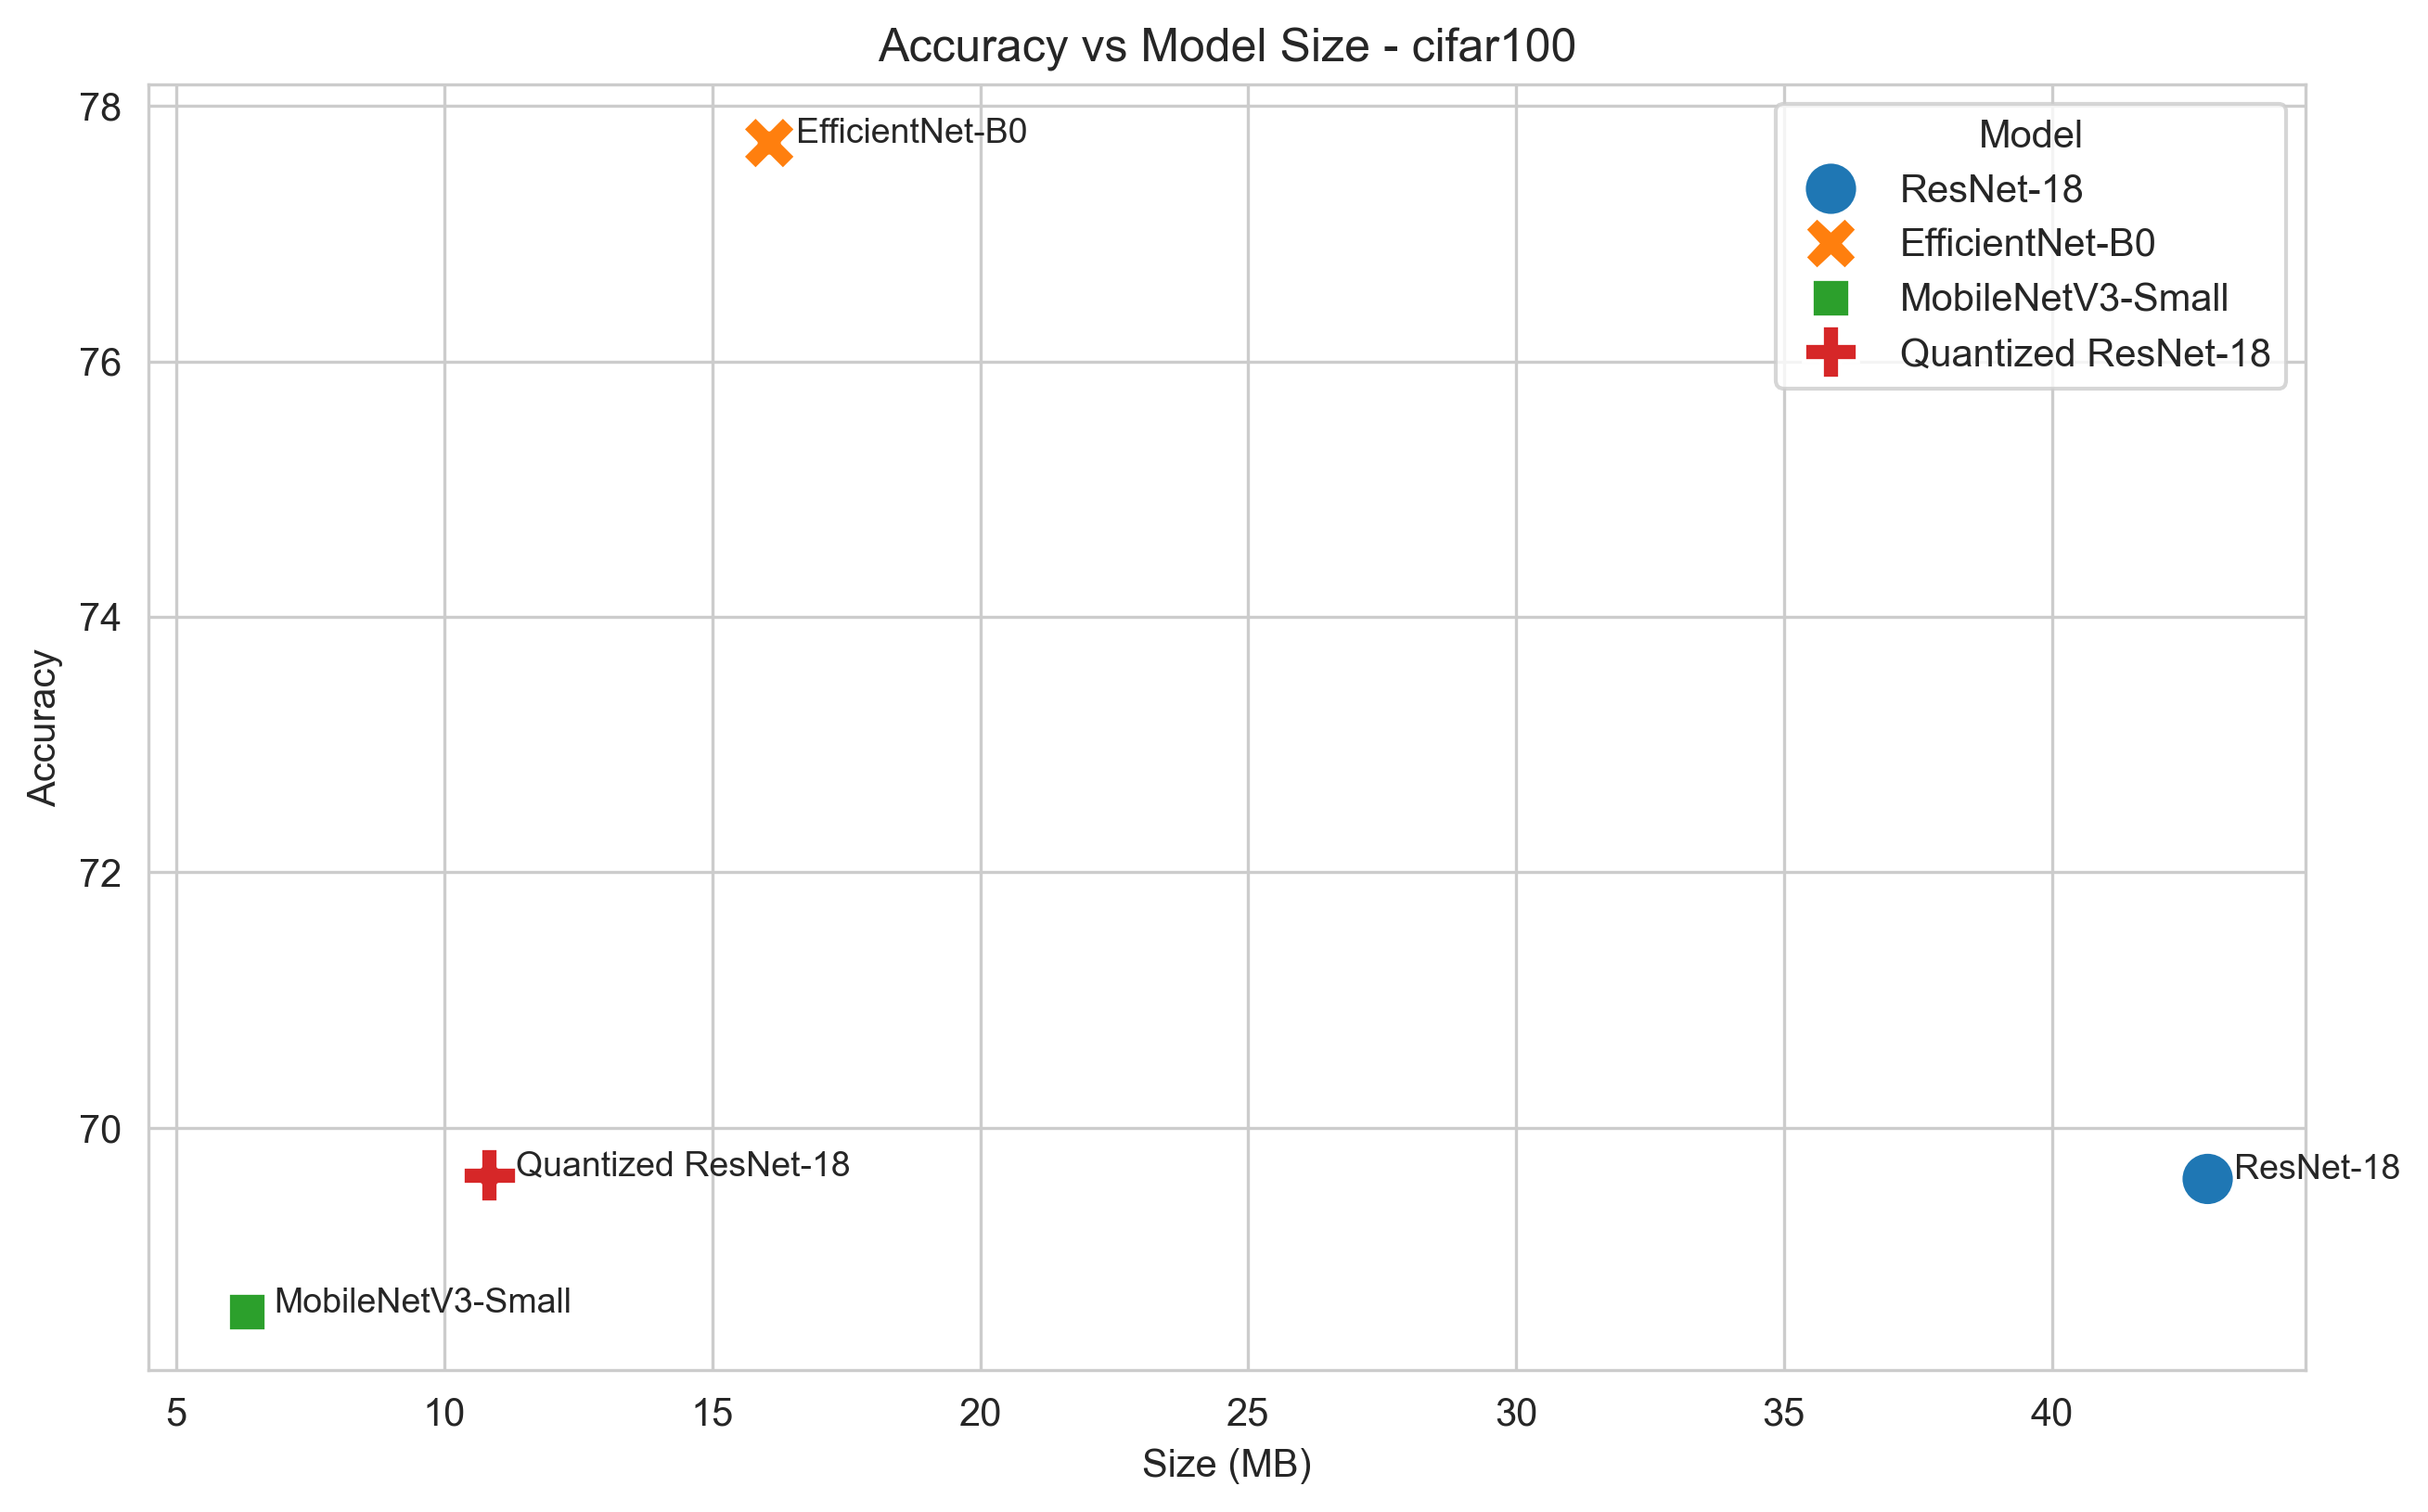

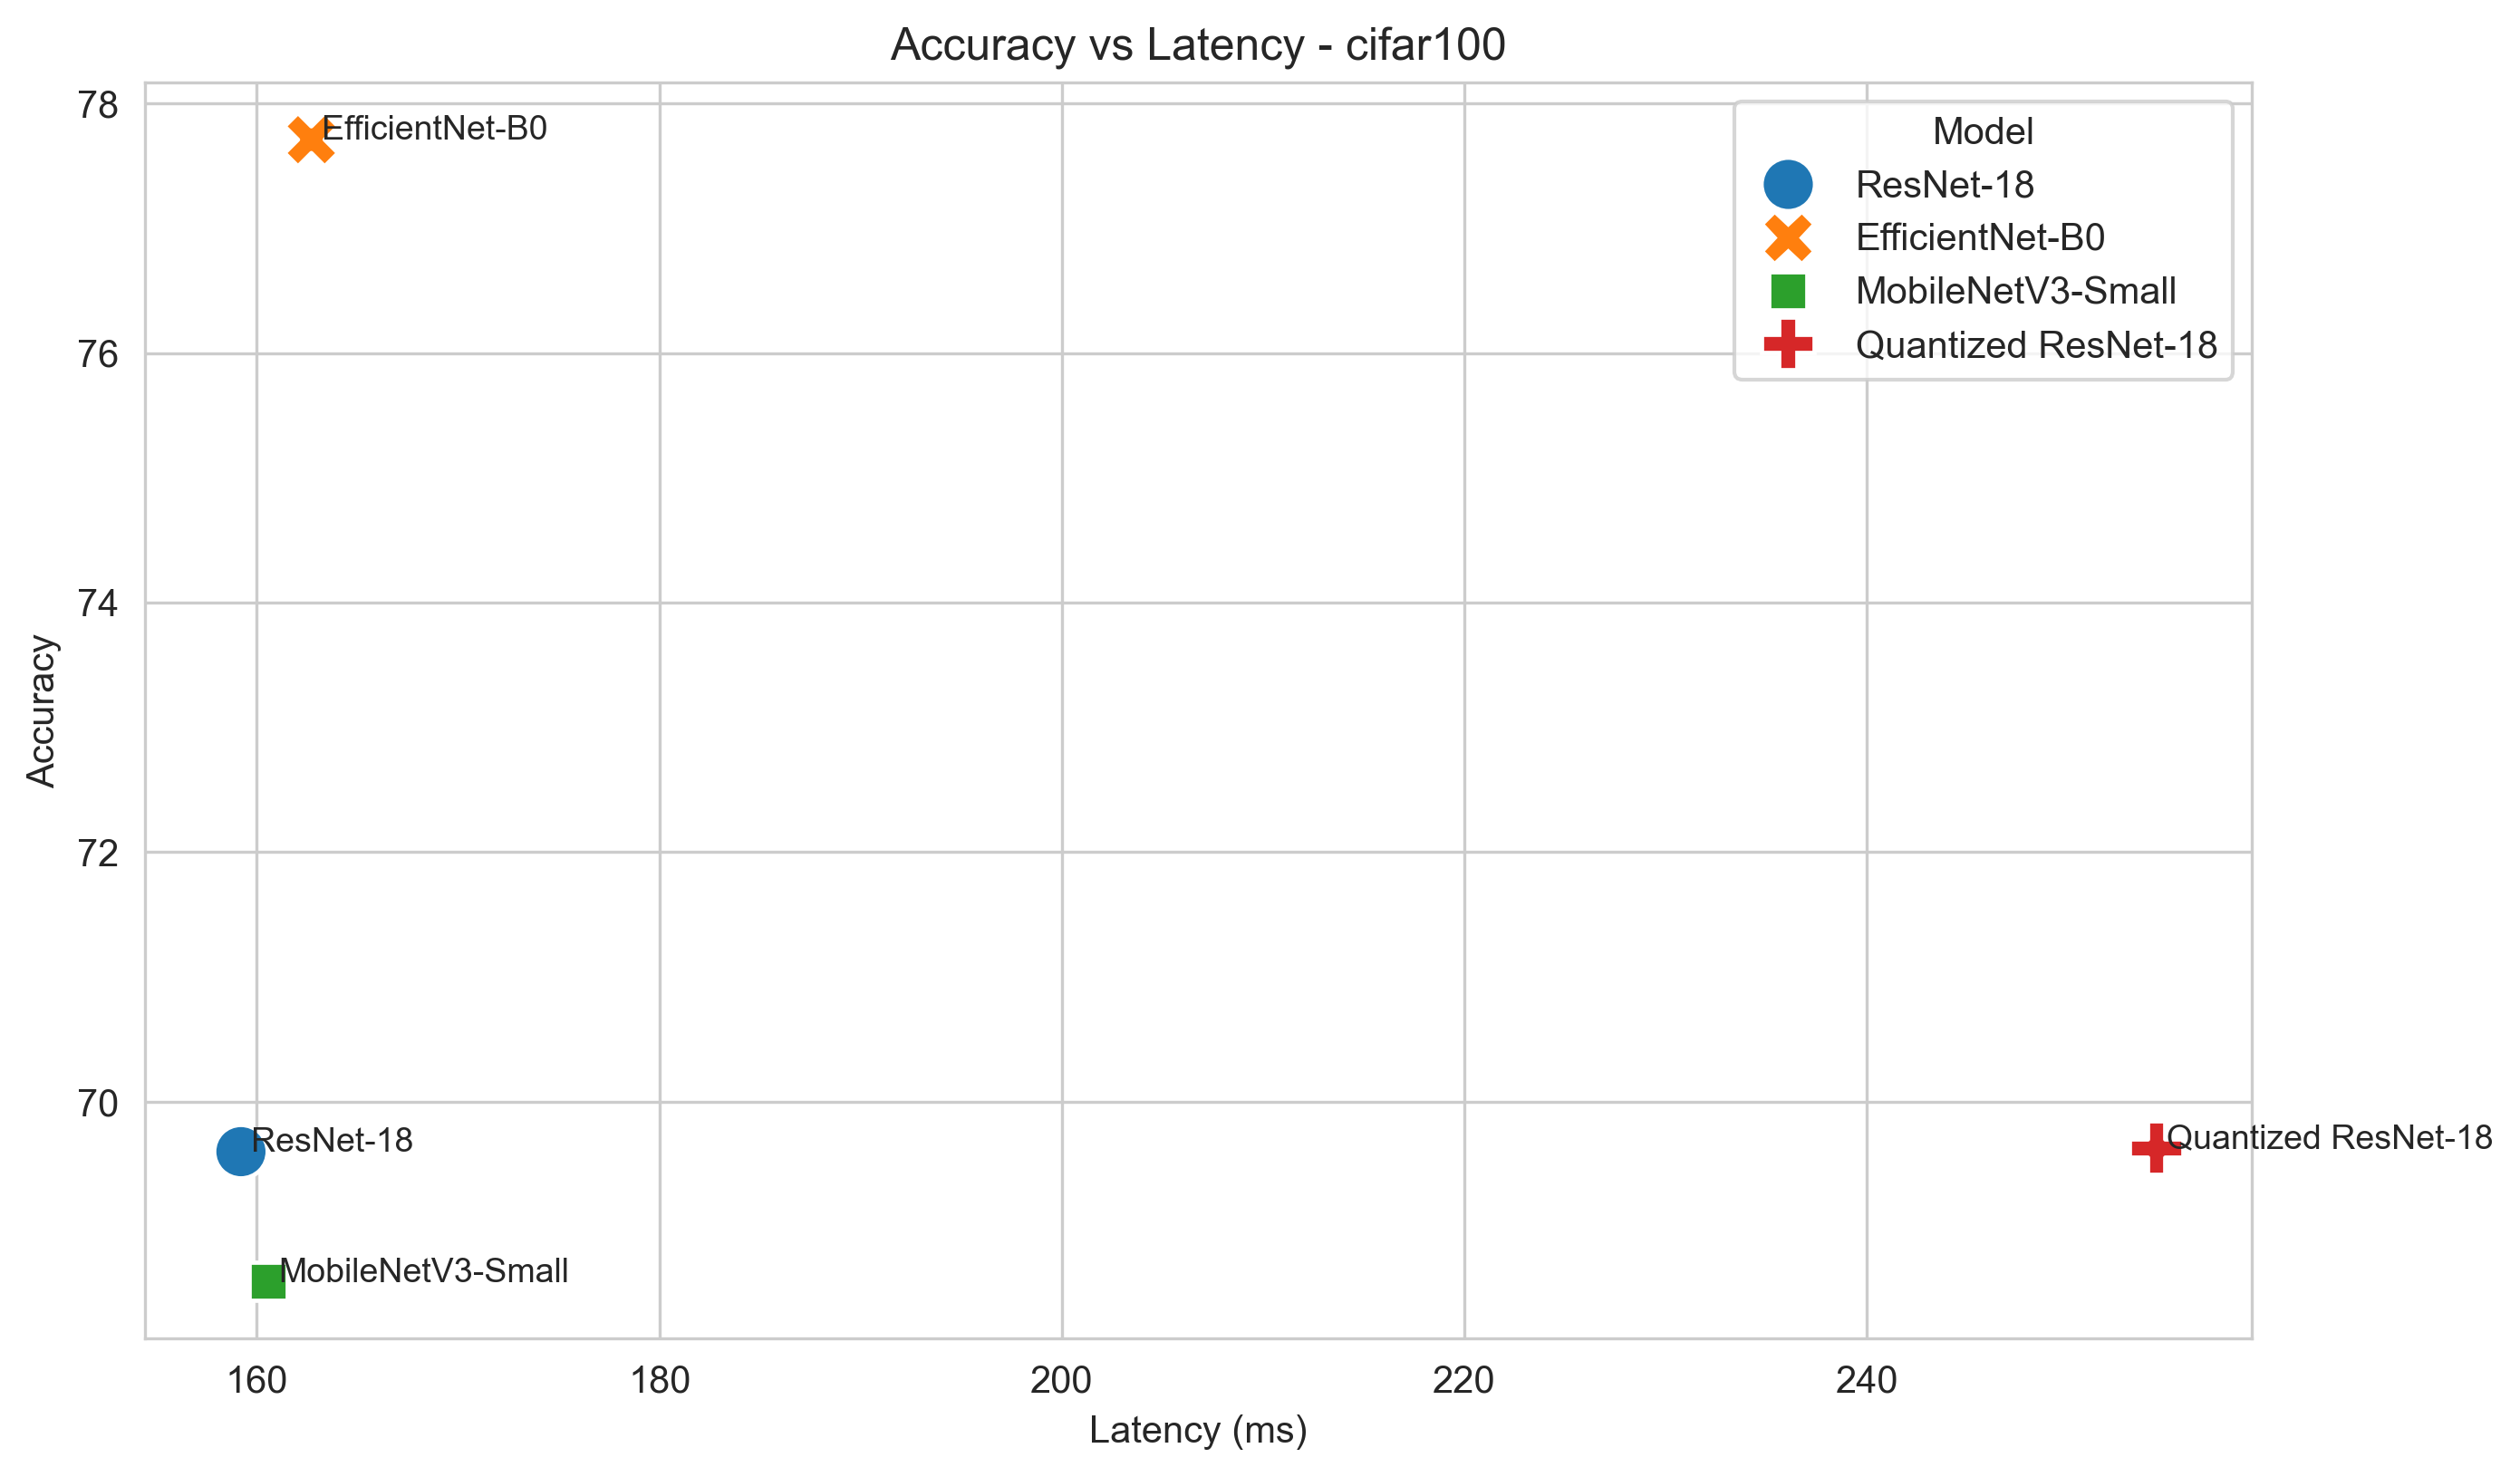

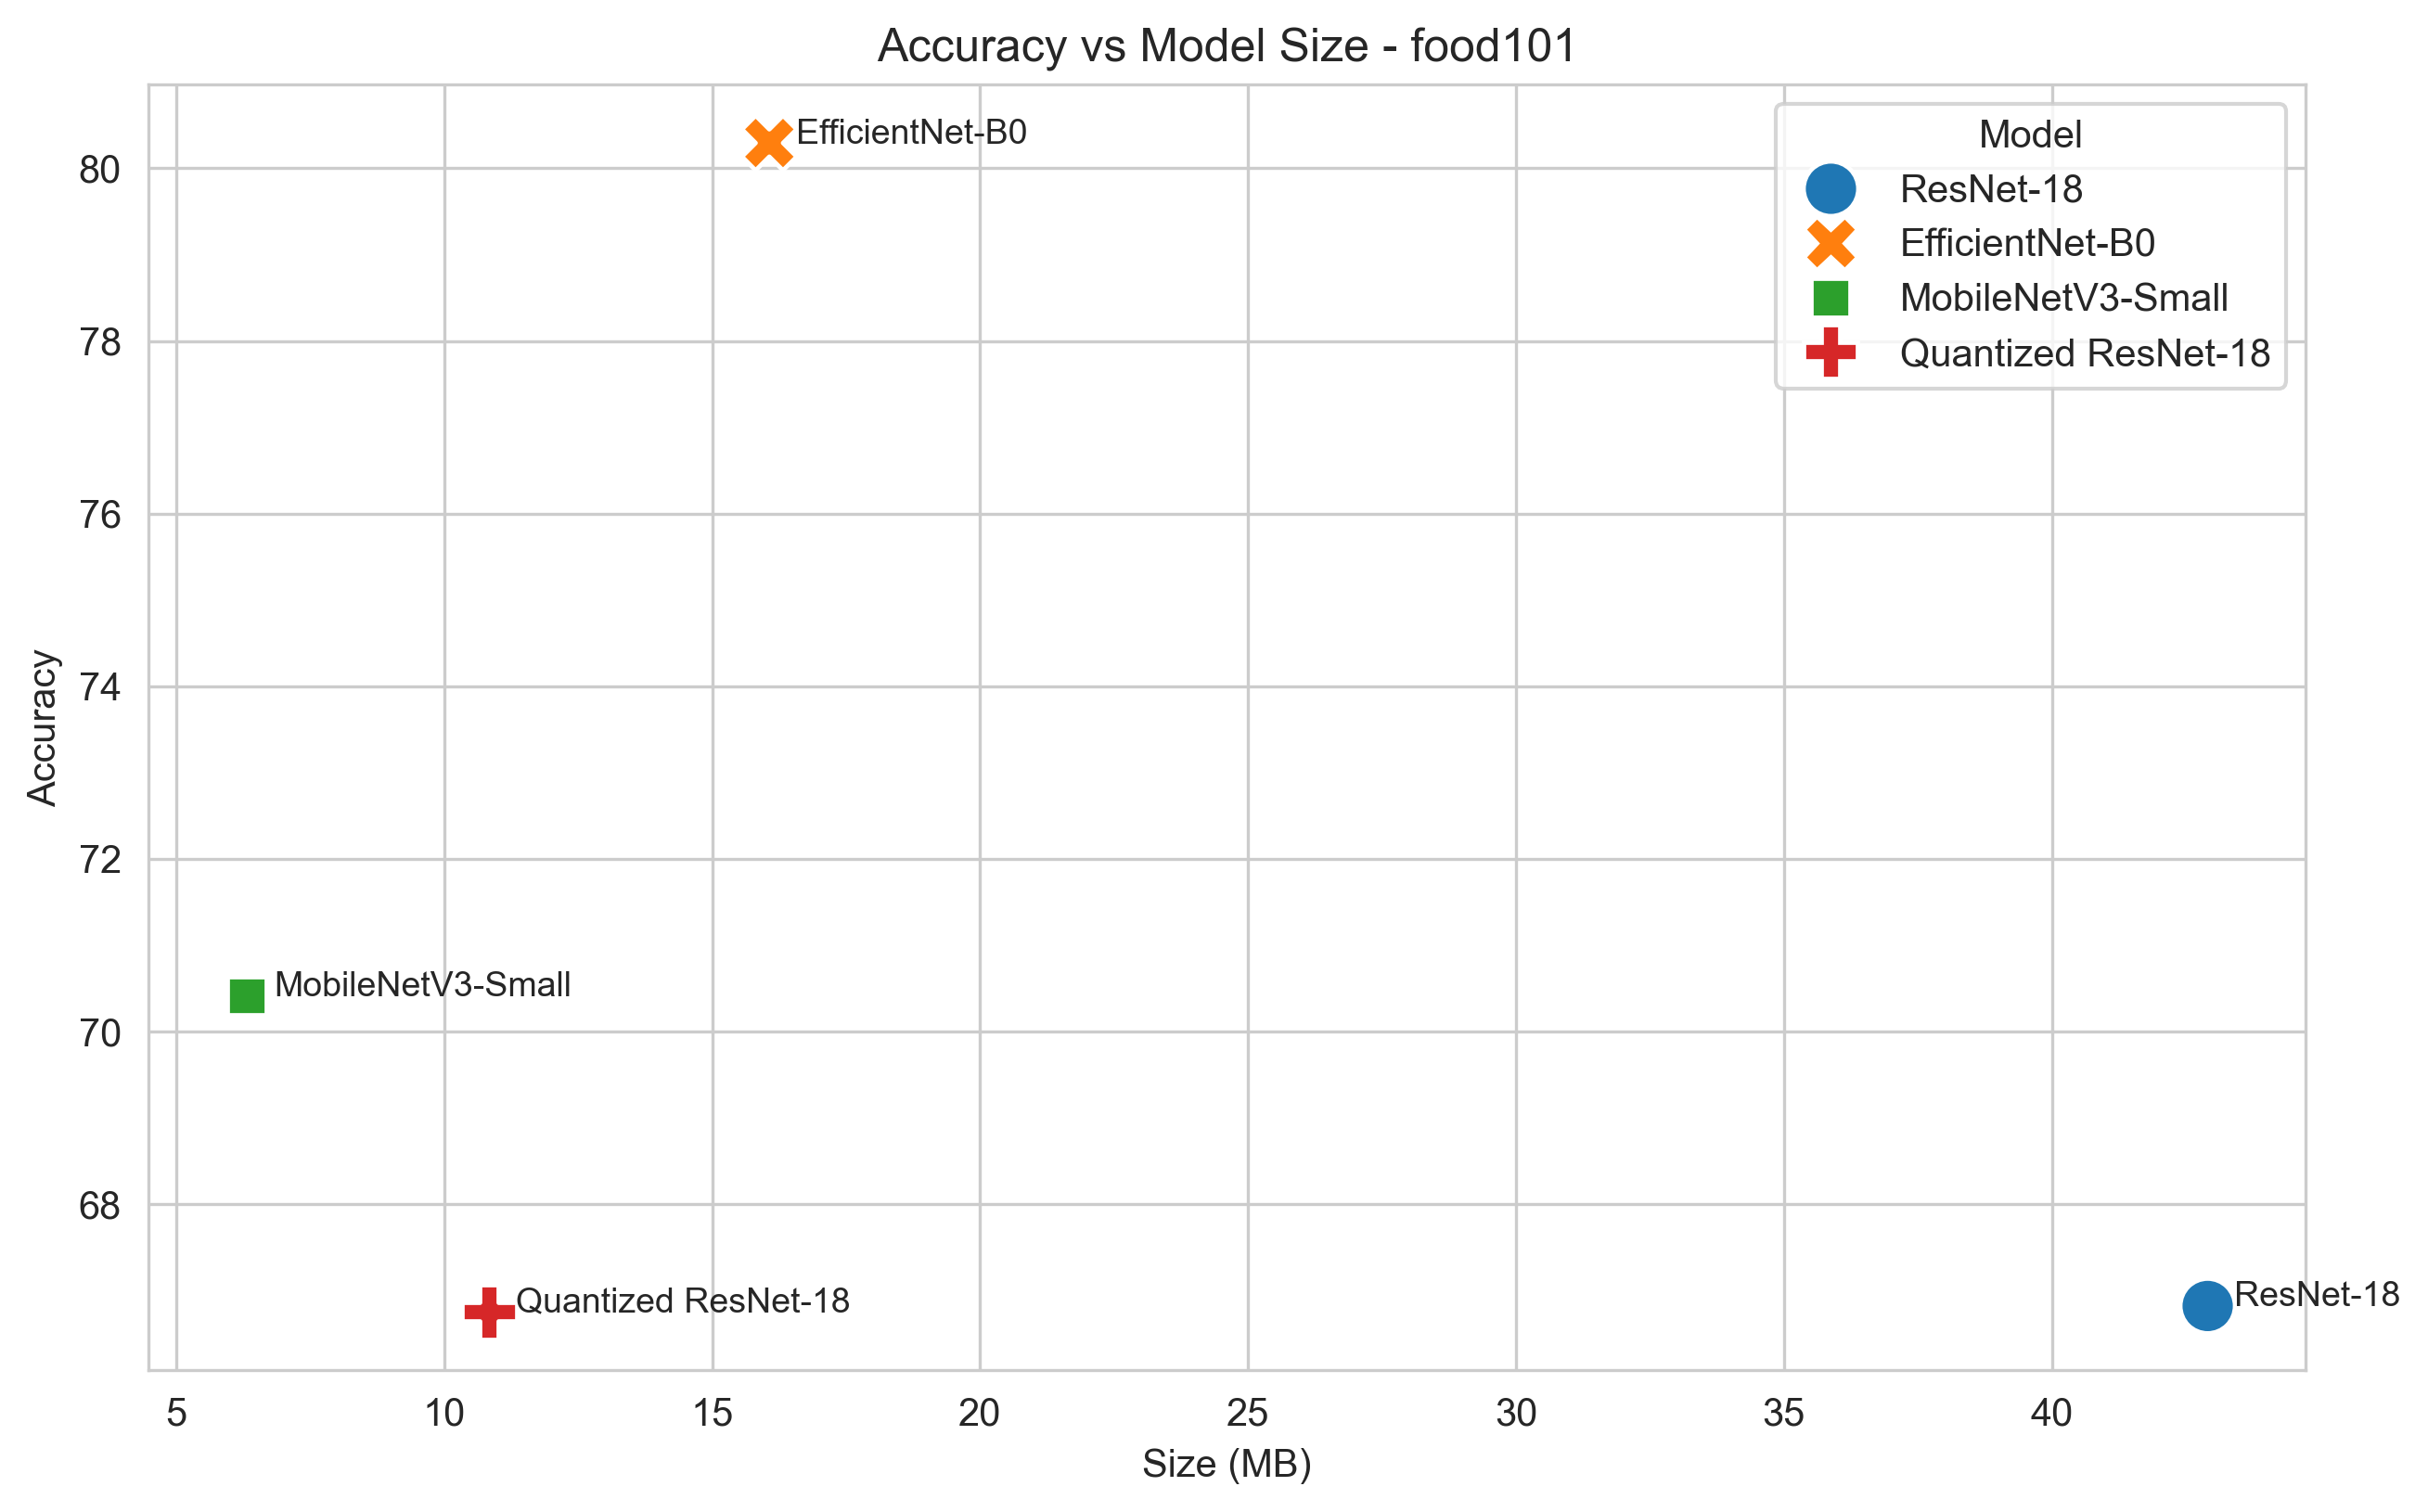

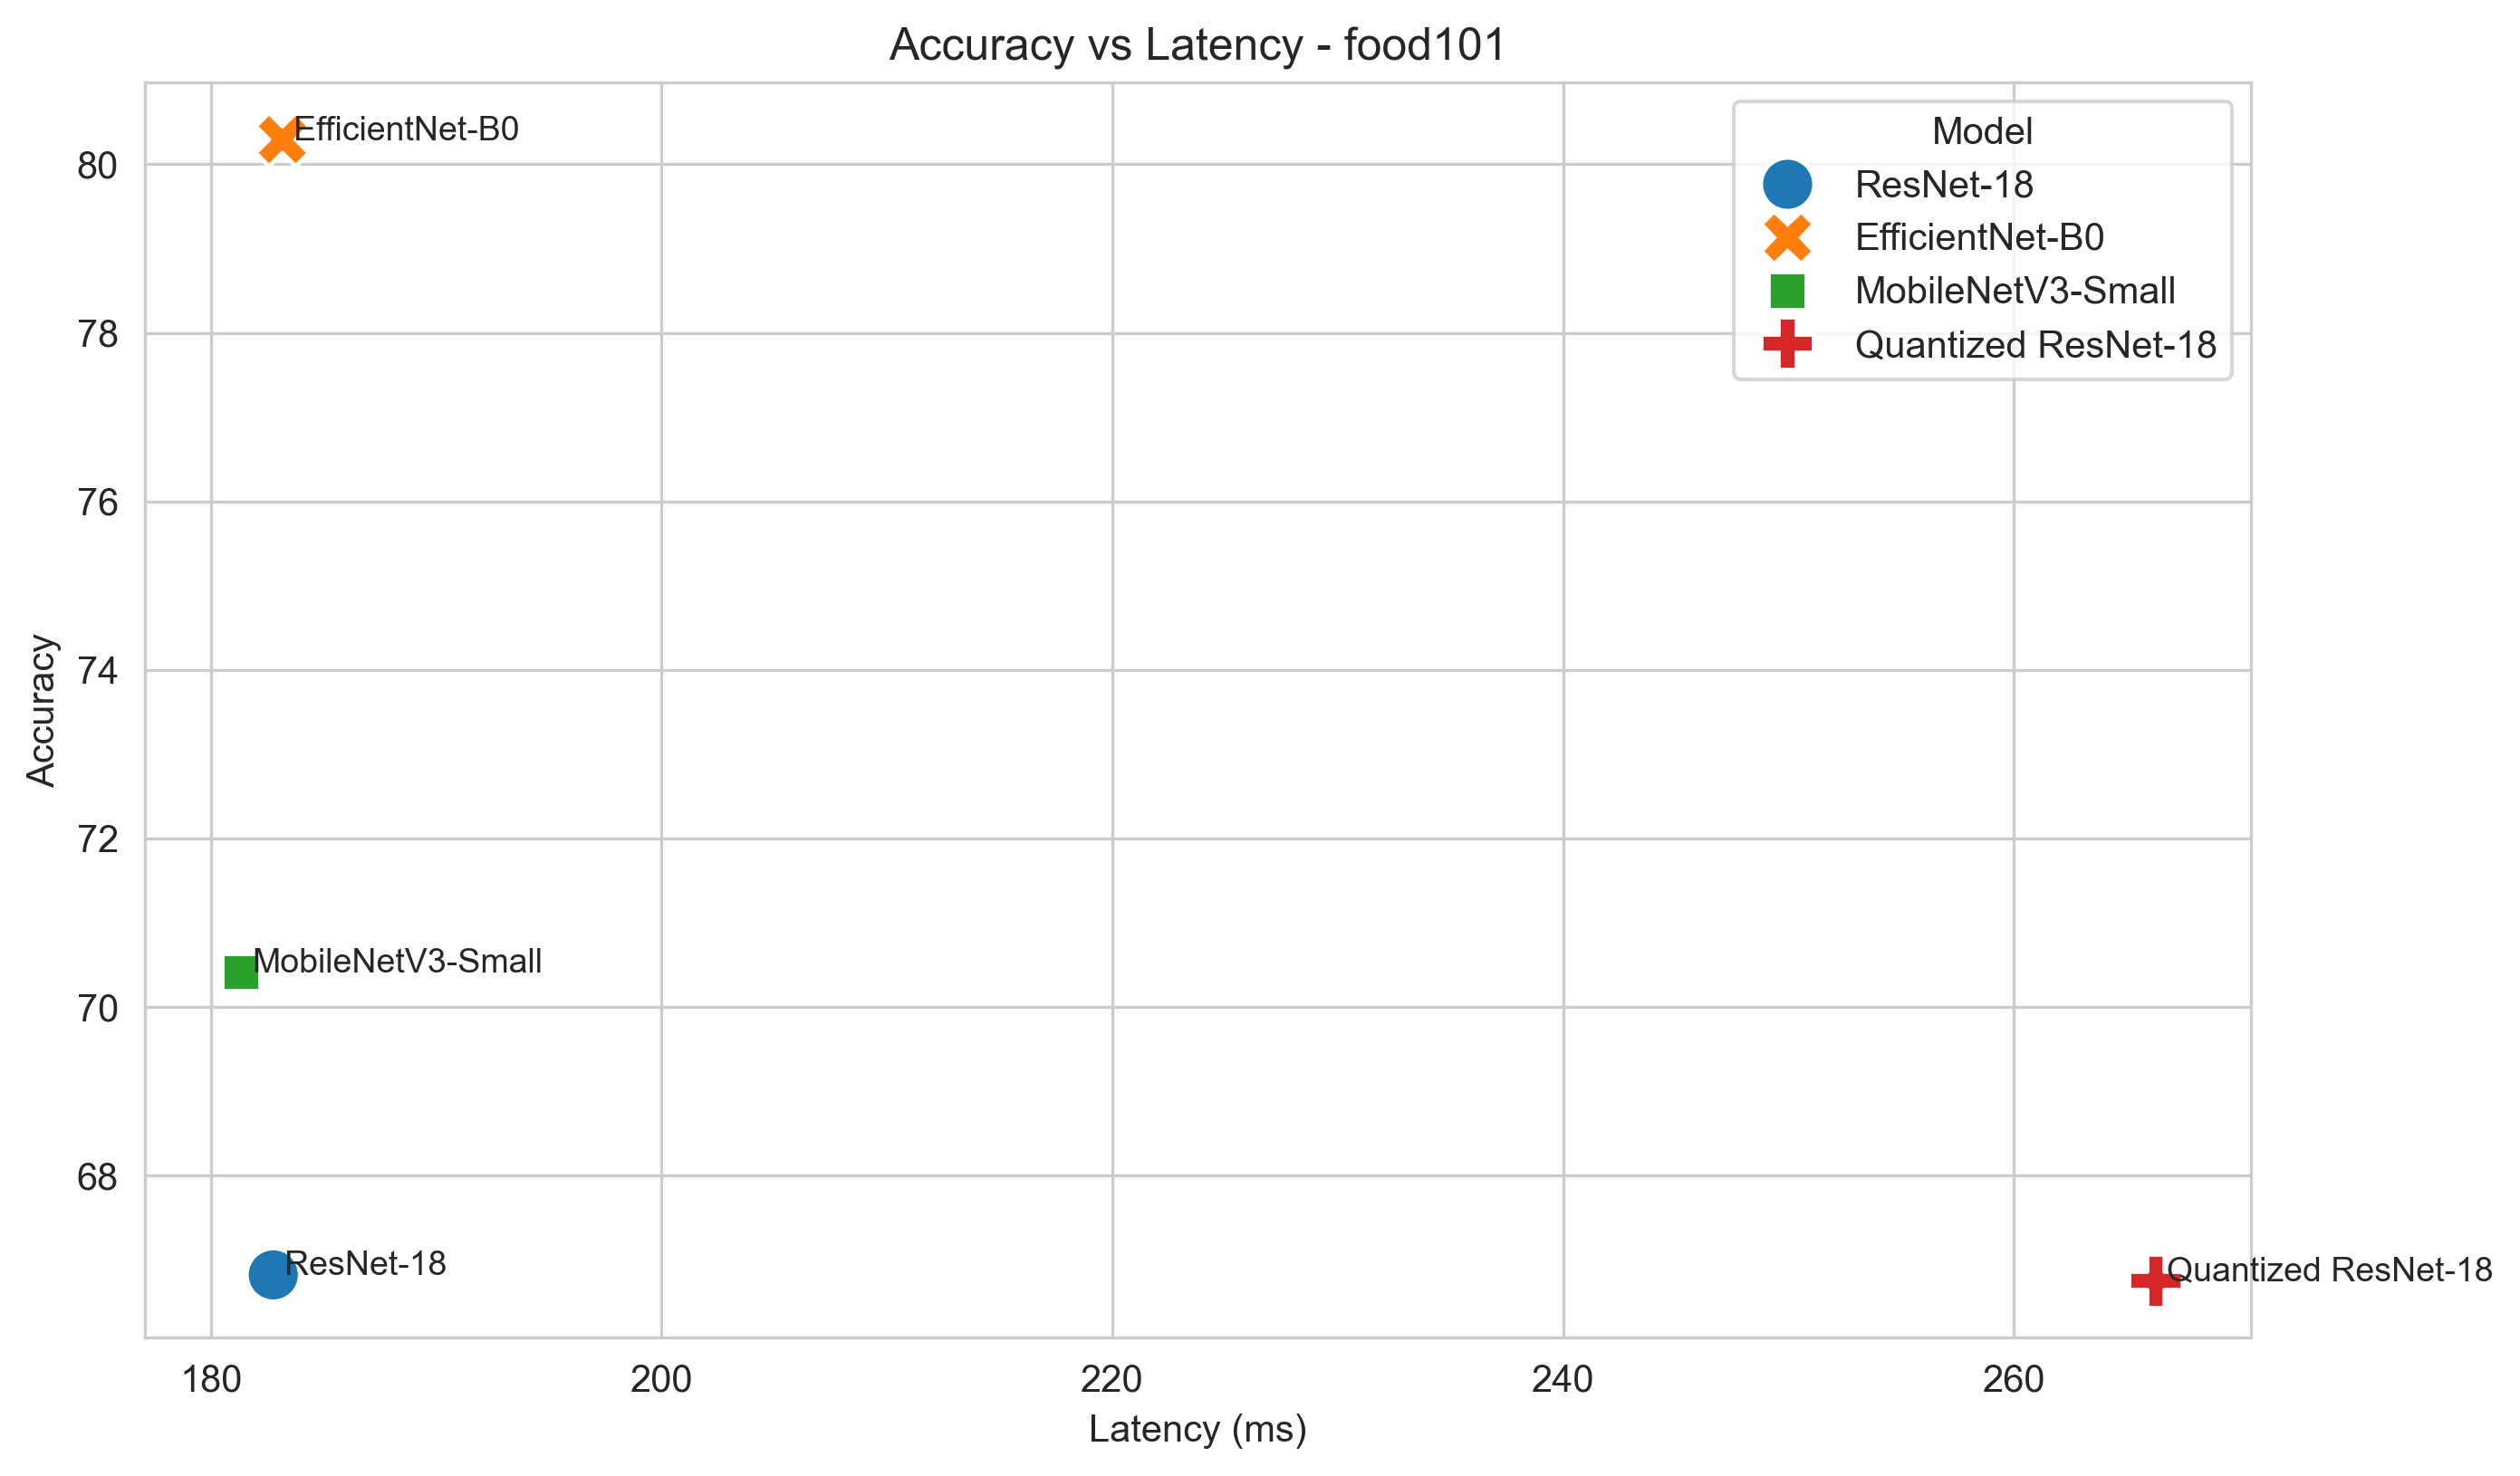

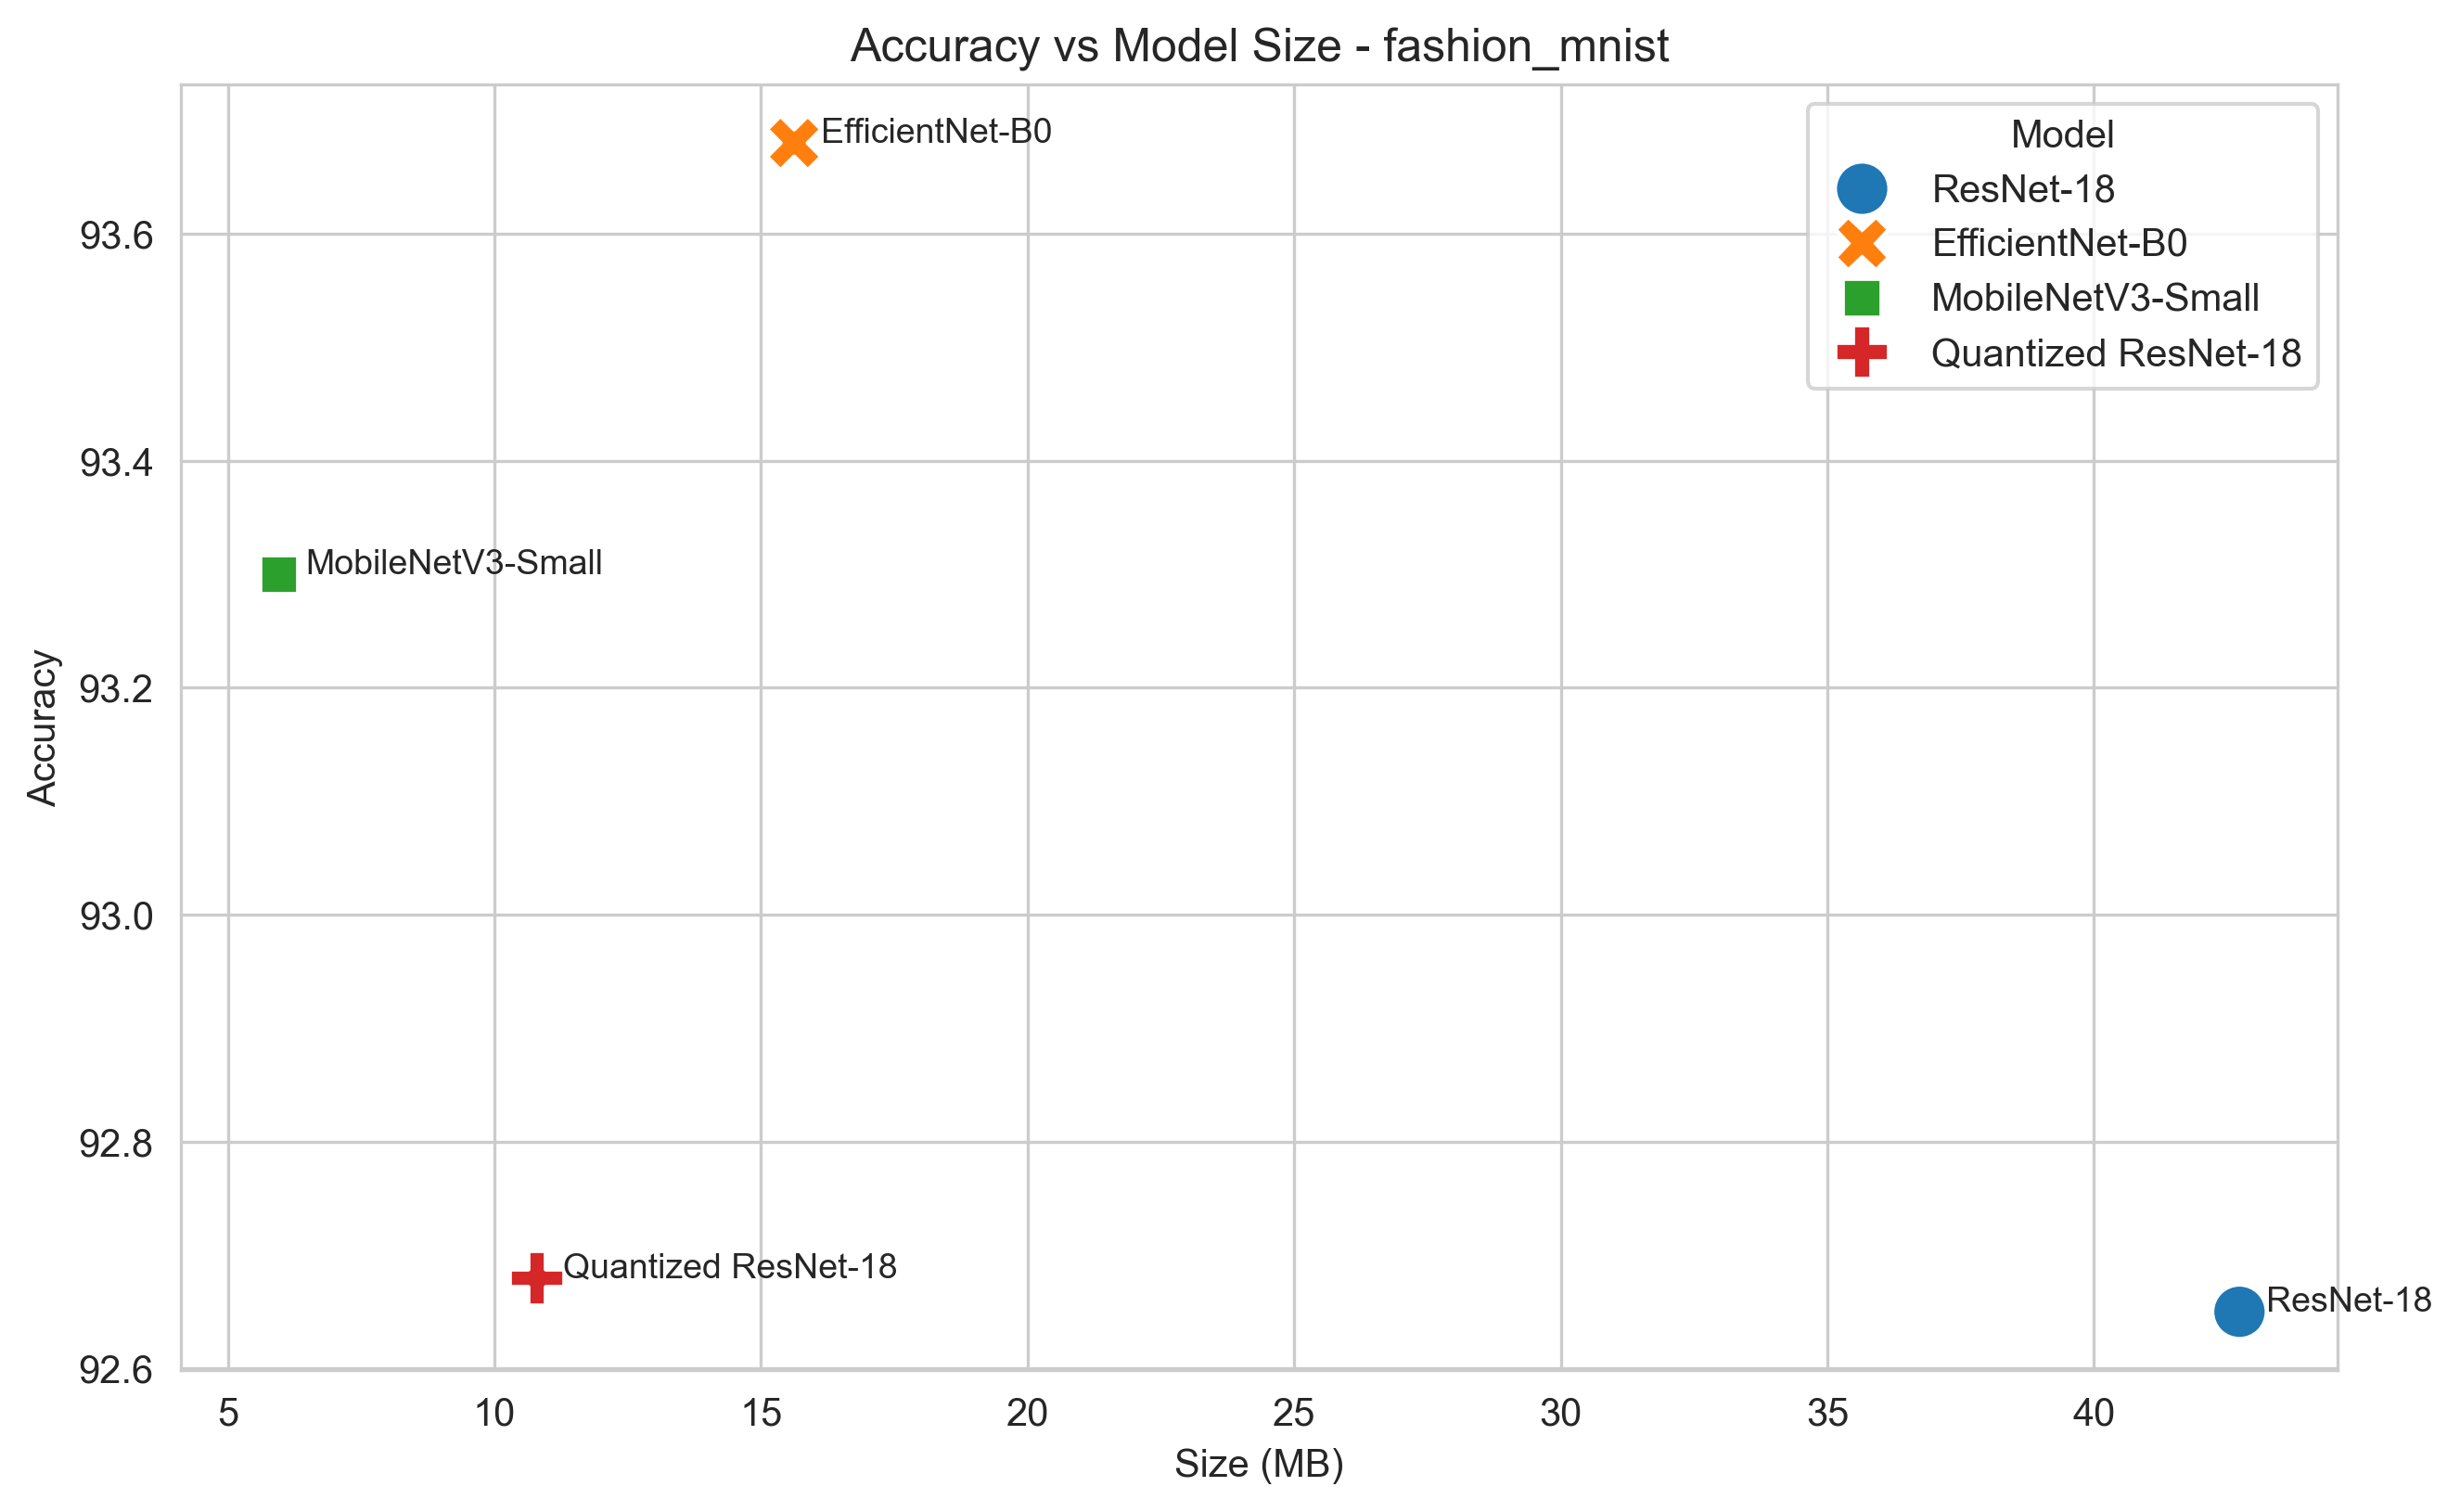

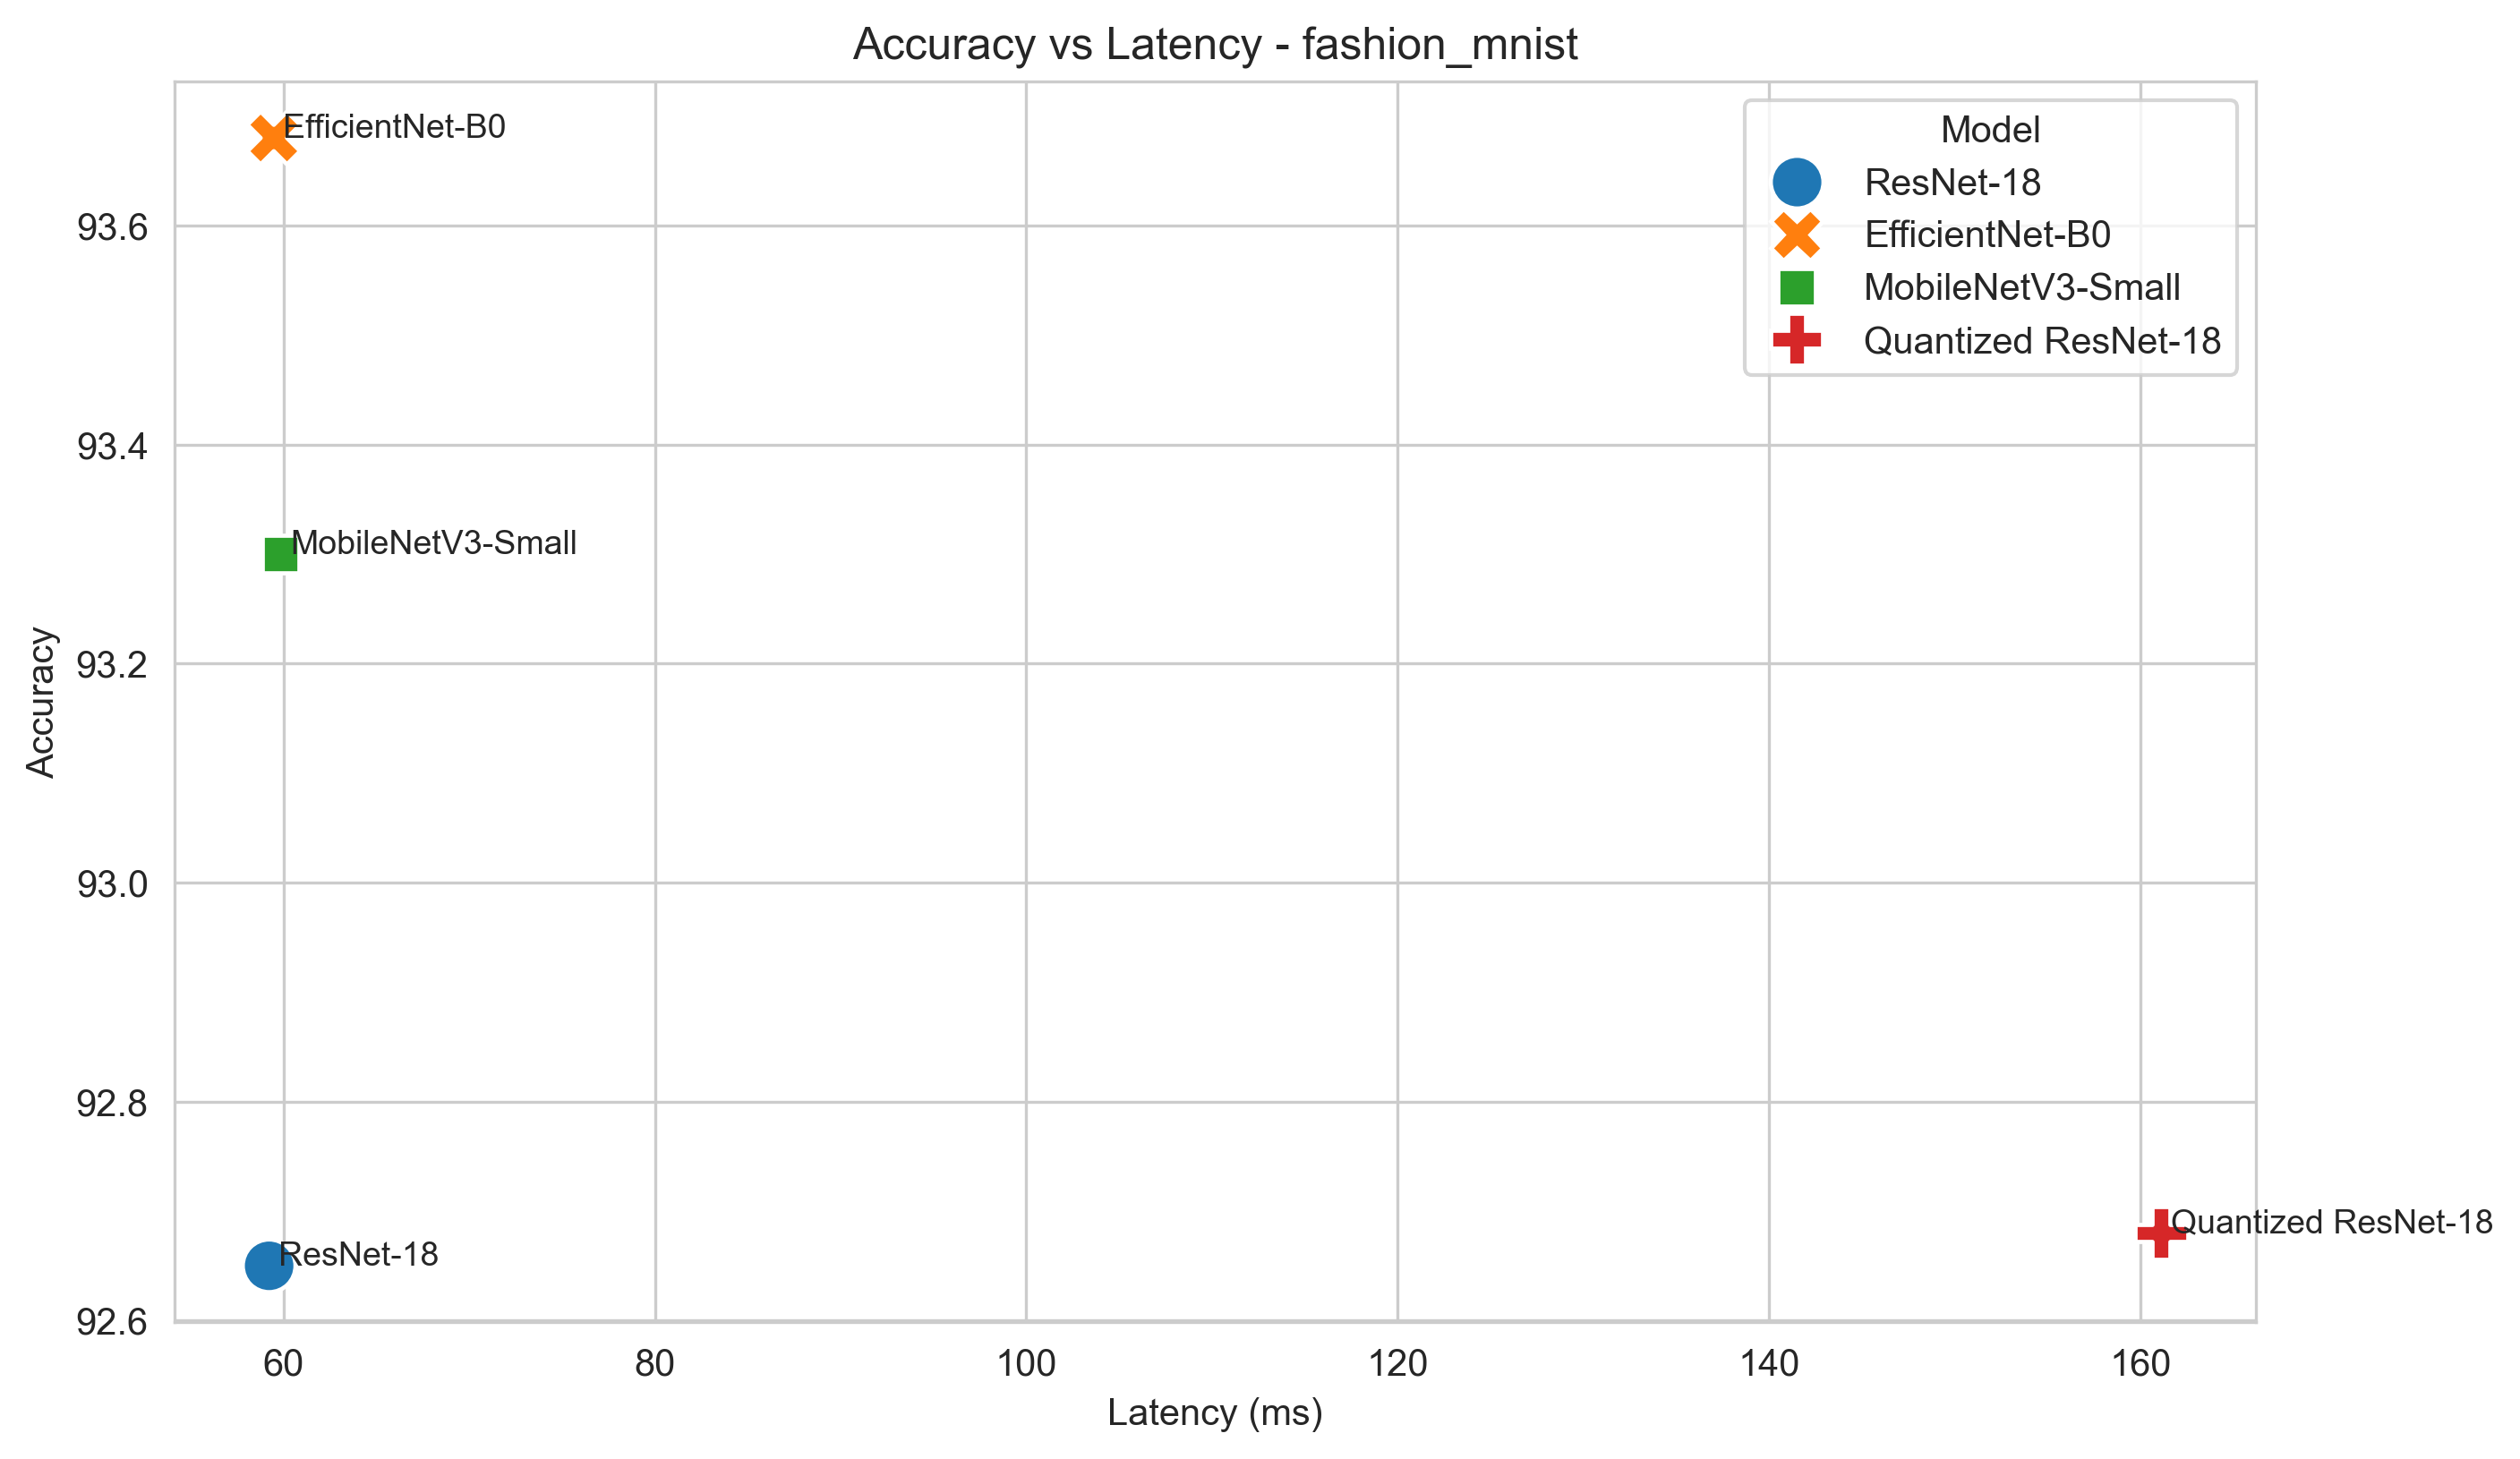

In [ ]:
# Plotting
def plot_results(df):
    datasets = df['Dataset'].unique()
    
    for dataset in datasets:
        subset = df[df['Dataset'] == dataset]
        
        # Accuracy vs Size
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=subset, x='Size (MB)', y='Accuracy', hue='Model', style='Model', s=200)
        
        for i in range(subset.shape[0]):
            plt.text(
                subset.iloc[i]['Size (MB)']+0.5, 
                subset.iloc[i]['Accuracy'], 
                subset.iloc[i]['Model'], 
                fontsize=9
            )
            
        plt.title(f'Accuracy vs Model Size - {dataset}')
        plt.grid(True)
        plt.savefig(os.path.join(CONFIG['results_dir'], f'{dataset}_acc_vs_size.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        # Accuracy vs Latency
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=subset, x='Latency (ms)', y='Accuracy', hue='Model', style='Model', s=200)
        
        for i in range(subset.shape[0]):
            plt.text(
                subset.iloc[i]['Latency (ms)']+0.5, 
                subset.iloc[i]['Accuracy'], 
                subset.iloc[i]['Model'], 
                fontsize=9
            )
            
        plt.title(f'Accuracy vs Latency - {dataset}')
        plt.grid(True)
        plt.savefig(os.path.join(CONFIG['results_dir'], f'{dataset}_acc_vs_latency.png'), dpi=300, bbox_inches='tight')
        plt.show()

plot_results(df_results)